##### Copyright 2021 Krzysztof Rusek
AGH University of Science and Technology

# Algae: Aggregated Linear Gaussian State Space Models - Demo

This demo code shows how to use run statistical inference about time-series parameters from observation at different levels of aggregation.


In [186]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%config InlineBackend.figure_format='retina'

## Time-series
Let's make a simple AR(1) time-series. Only a small part is observed directly. The rest is available only as of the averages of 4 consecutive observations in non-overlapping windows.

In [117]:
ts = [np.random.normal(scale=0.1)]
n_fine=6
n_coarse=5

for i in range(n_fine+4*n_coarse):
    ts.append(0.2*ts[-1]+np.random.normal(scale=0.1) )

_ts=ts
ts2 = pd.Series(np.mean(np.reshape(ts[:-(n_fine+1)],(n_coarse,4)), axis=1))
ts = pd.Series(ts[-(n_fine+1):])

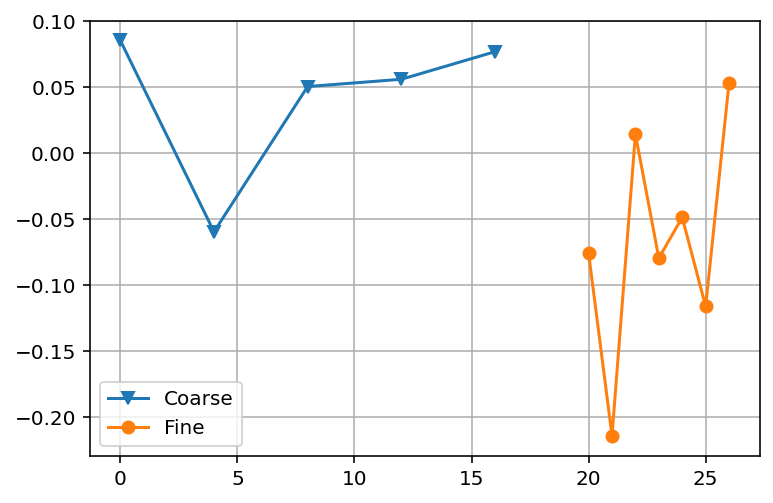

In [187]:
plt.plot(np.arange(0,4*n_coarse,4), ts2,'-v',label='Coarse')
plt.plot(np.arange(4*n_coarse,4*n_coarse+n_fine+1), ts,'-o',label='Fine')
plt.legend()
plt.grid(True)


## Code

Since code in this repository is an experimental implementation for research purposes, we have no proper API. Let's make one. Here we use a Mixin design pattern to add a definition of the custom model to our implementation.

In [154]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
sts=tfp.sts

class ModelMixin:
    dtype=tf.float64
    
    def model(self):
        print('Using mixin')
        prior = tfd.MultivariateNormalDiag(loc=tf.convert_to_tensor([0.5], dtype=self.dtype) , 
                                           scale_diag=tf.convert_to_tensor([0.3], dtype=self.dtype)
                                          )
        autoregressive = sts.Autoregressive(
            order=1,
            coefficients_prior=prior,
            observed_time_series=self.train_ts,
            name='autoregressive')
        model = sts.Sum([autoregressive], observed_time_series=self.train_ts)
        return model


In [155]:
import ssm

class TimeSeriesPredictor(ModelMixin, ssm.TimeSeriesPredictor):
    pass

class AggregatedPredictor(ModelMixin, ssm.AggregatedPredictor):
    pass

## Fine-grained model
Let's begin with fitting the AR(1) model to the fine-grained part only. We use Stochastic Variational Inference with prior assigning mostly positive values for the autoregressive coefficient.



Using mixin


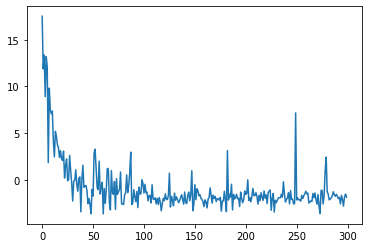

In [156]:
predictor = TimeSeriesPredictor(num_forecast_steps=1, ts=ts)
elbo=predictor.fit(num_variational_steps=300)
plt.plot(elbo)



## Fine+ Coarse-grained model
In this step, we improve the estimation by using more observation ad aggregation level 4.

Using mixin


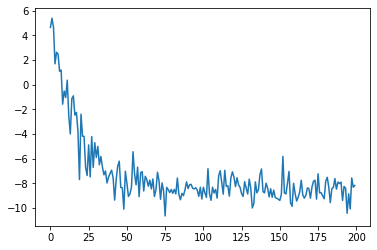

In [157]:
ag_predictor = AggregatedPredictor(num_forecast_steps=1, ts=ts.astype(np.float32), ts2=ts2.astype(np.float32))
ag_predictor.dtype=tf.float32

elbo2=ag_predictor.fit(num_variational_steps=200)
plt.plot(elbo2)



## Results

Below we compare the posteriors obtained from two models.
Additional observations improve our estimations substantially (the true value of 0.2 is almost at the mode of the posterior. 


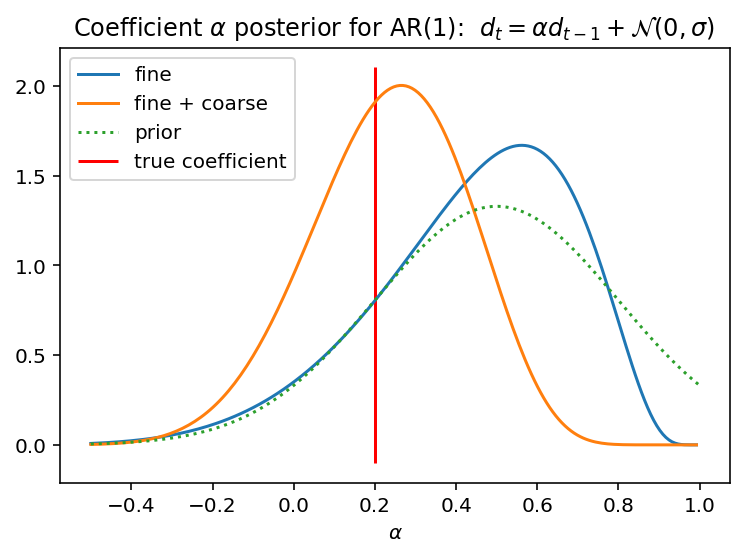

In [222]:
import seaborn as sns
x=np.linspace(-0.5,1,200)[...,np.newaxis]
plt.plot(x,predictor.posterior.model['autoregressive/_coefficients'].prob(x), label="fine")
plt.plot(x,ag_predictor.posterior.model[1].prob(x), label="fine + coarse")

prior = tfd.MultivariateNormalDiag(loc=tf.convert_to_tensor([0.5], dtype=x.dtype) , 
                                   scale_diag=tf.convert_to_tensor([0.3], dtype=x.dtype)
                                  )

plt.plot(x,prior.prob(x),':', label="prior")

plt.vlines(0.2, *plt.ylim(), color='red', label='true coefficient')
plt.xlabel(r'$\alpha$')
plt.legend()
plt.title(r'Coefficient $\alpha$ posterior for AR(1):  $d_t=\alpha d_{t-1}+\mathcal{N}(0,\sigma)$ ')
plt.savefig('posterior_c.svg')